In [2]:
#include google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding
import tensorflow.keras.backend as K
import tensorflow.keras as keras
from sklearn import preprocessing

import random


In [0]:
# define paths
output_path = '/content/drive/My Drive/Fax/Master Theses/output-autoencoder2'
model_path = output_path+'/model.h5'
encoder_path = output_path+'/encoder.h5'
data_path = '/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/'


In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])


In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


In [8]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,1.0,0.726248,0.242424,0.109755,0.0,0.369048,0.633262,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,1.0,0.628019,0.212121,0.100242,0.0,0.380952,0.765458,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,1.0,0.710145,0.272727,0.140043,0.0,0.250000,0.795309,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,1.0,0.740741,0.318182,0.124518,0.0,0.166667,0.889126,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,1.0,0.668277,0.242424,0.149960,0.0,0.255952,0.746269,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0.01108


In [26]:
# # pick a window size
# sequence_length = 10

# def gen_sequence(id_df, seq_length, seq_cols):
    
#     data_matrix = id_df[seq_cols].values
#     num_elements = data_matrix.shape[0]
#     for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
#         yield data_matrix[start:stop, :]
        
# # pick the feature columns 

# sensor_cols = ['s' + str(i) for i in range(1,22)]
# sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
# sequence_cols.extend(sensor_cols)

# # TODO for debug 
# # val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
# val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
# print(len(val))

# # generator for the sequences
# # transform each id of the train dataset in a sequence
# seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
#            for id in train_df['id'].unique())

# # generate sequences and convert to numpy array
# seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
# print(seq_array.shape)


# pick the feature columns 
#take only 14 valulable sensors  2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 17, 20, and 21
sensor_cols= ['s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

train_x = train_df[sequence_cols].values.astype(np.float32)
print(train_x.shape)

(20631, 18)


In [0]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [15]:
##################################
# Autoencoder
##################################
n_samples = train_x.shape[0]
nb_features = train_x.shape[1]

input_d = Input(shape=(nb_features,))
encoded = Dense(32, activation='relu')(input_d)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(nb_features, activation='sigmoid')(decoded)

autoencoder = Model(input_d, decoded)
autoencoder.compile('adam', 'mae')

autoencoder.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])
autoencoder.summary()
history = autoencoder.fit(train_x, train_x,
                epochs=200,
                verbose=2,
                batch_size=256,
                shuffle=True,
                validation_data=(train_x, train_x),
                callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                      keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                608       
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 16)                144       
_________________________________________________________________
dense_22 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_23 (Dense)             (None, 18)                594 

dict_keys(['loss', 'mae', 'r2_keras', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_r2_keras', 'val_root_mean_squared_error'])


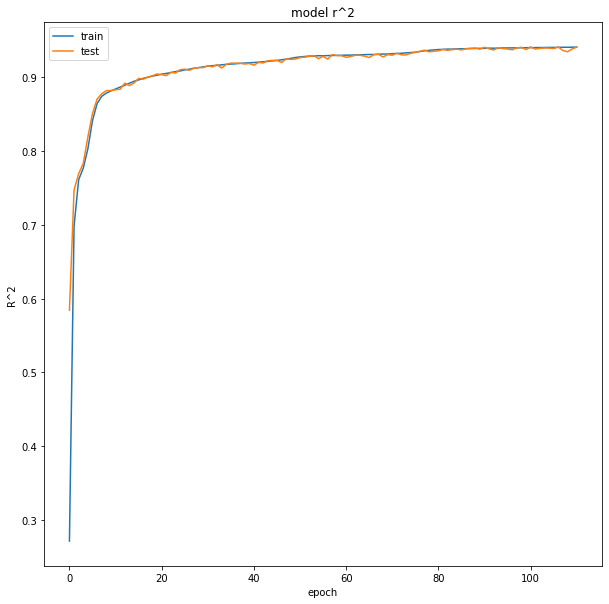

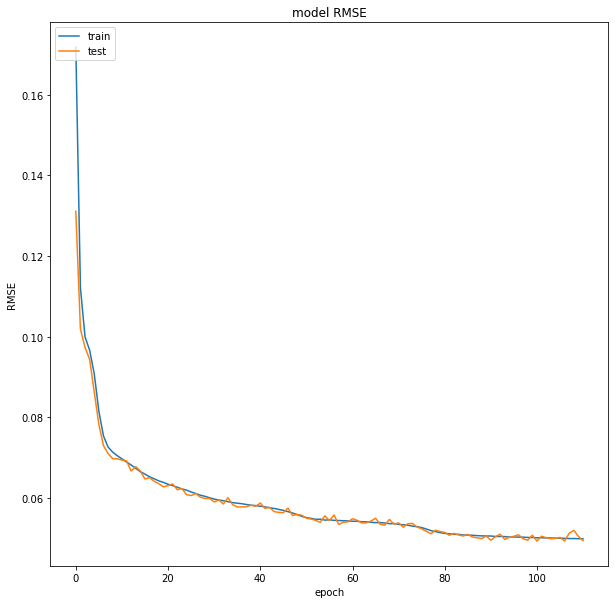

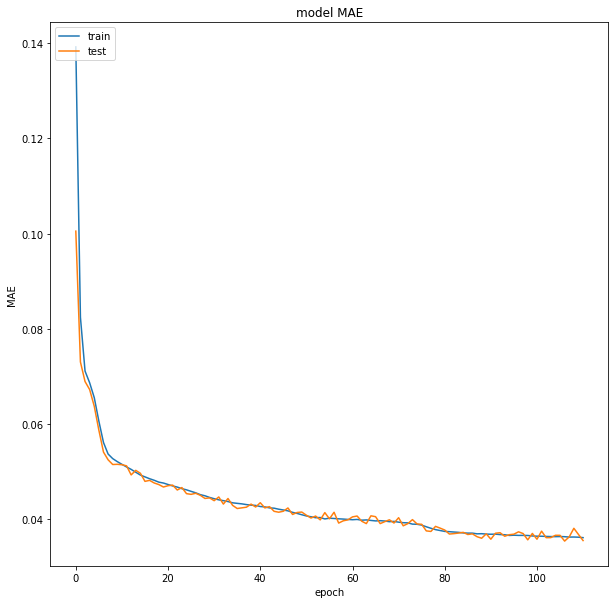

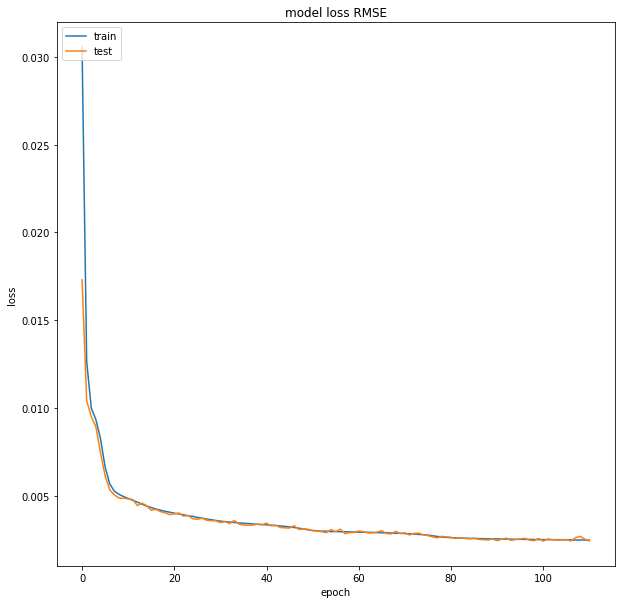

In [17]:

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_r2.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_RMSE.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss RMSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_regression_loss.png")




In [18]:

# get encoder
encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[3].output)
encoder.summary()
encoder.save(encoder_path)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                608       
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
Total params: 1,272
Trainable params: 1,272
Non-trainable params: 0
_________________________________________________________________


In [19]:
encoded_data = encoder.predict(train_x,verbose=1, batch_size=200)
encoded_df = pd.DataFrame(encoded_data) 

20631/20631 [==============================] - 0s 6us/sample


In [67]:
autoencoder_data = autoencoder.predict(train_x,verbose=1, batch_size=200)
autoencoder_df = pd.DataFrame(autoencoder_data) 


#add column names
autoencoder_df.columns = train_df[sequence_cols].columns

# Using DataFrame.insert() to add a column 
autoencoder_df.insert(0, "id", train_df['id'], True) 

20631/20631 [==============================] - 0s 6us/sample


In [0]:
encoded_cols_id = ['id', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8']

# Convert the dictionary into DataFrame 
encoded_df = pd.DataFrame(encoded_data) 
  
# Using DataFrame.insert() to add a column 
encoded_df.insert(0, "id", train_df['id'], True) 
#add column names
encoded_df.columns = encoded_cols_id

encoded_cols = ['s' + str(i) for i in range(1,9)]

In [0]:
def display_encoded_data(data, col_names, rul=None):
    
    samples = data.shape[0]
    x = np.arange(samples)
    
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = math.ceil(n / nrows)
    
    fig = plt.figure(figsize=(20, n))
    
    print(" Samples: {}, Features: {}".format( samples, n))
    
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(m)
        
        y = data[m].values
        ax.plot(x, y)
        
    
    plt.tight_layout()
    plt.show()

In [0]:
# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]

# Twenty one sensor columns
#sensor_cols = ['s' + str(i) for i in range(1,22)]

def display_data(df, engine_id, col_names, rul=None):
    
    engine_data = df[df['id'] == engine_id]
    samples = engine_data.shape[0]
    x = np.arange(samples)
    
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = math.ceil(n / nrows)
    
    print("rows: {}, cols: {}".format( nrows, ncols))
    fig = plt.figure(figsize=(20, n))
    
    print("Engine: {}, Samples: {}, Features: {}".format( engine_id, samples, n))
    
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(m)
        
        y = engine_data[m].values
        ax.plot(x, y)
        
        if rul:
            ax.axvline(x=rul, color='r')
    
    plt.tight_layout()
    plt.show()

rows: 1, cols: 3
Engine: 1, Samples: 192, Features: 3


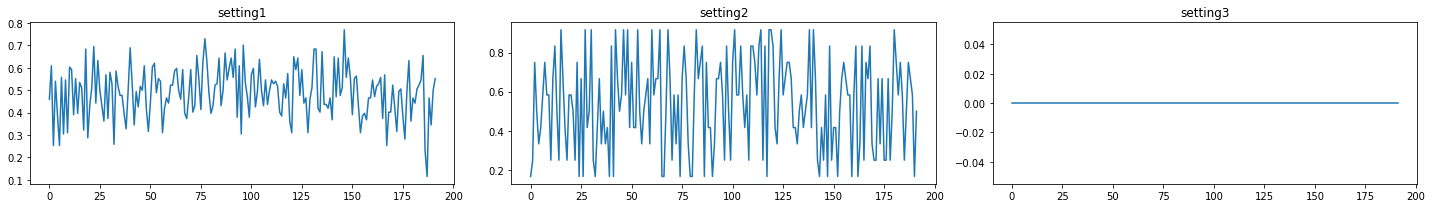

In [64]:
display_data( train_df, 1, setting_cols)

In [56]:
sensor_cols

['s2',
 's3',
 's4',
 's7',
 's8',
 's9',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

rows: 4, cols: 4
Engine: 3, Samples: 179, Features: 14


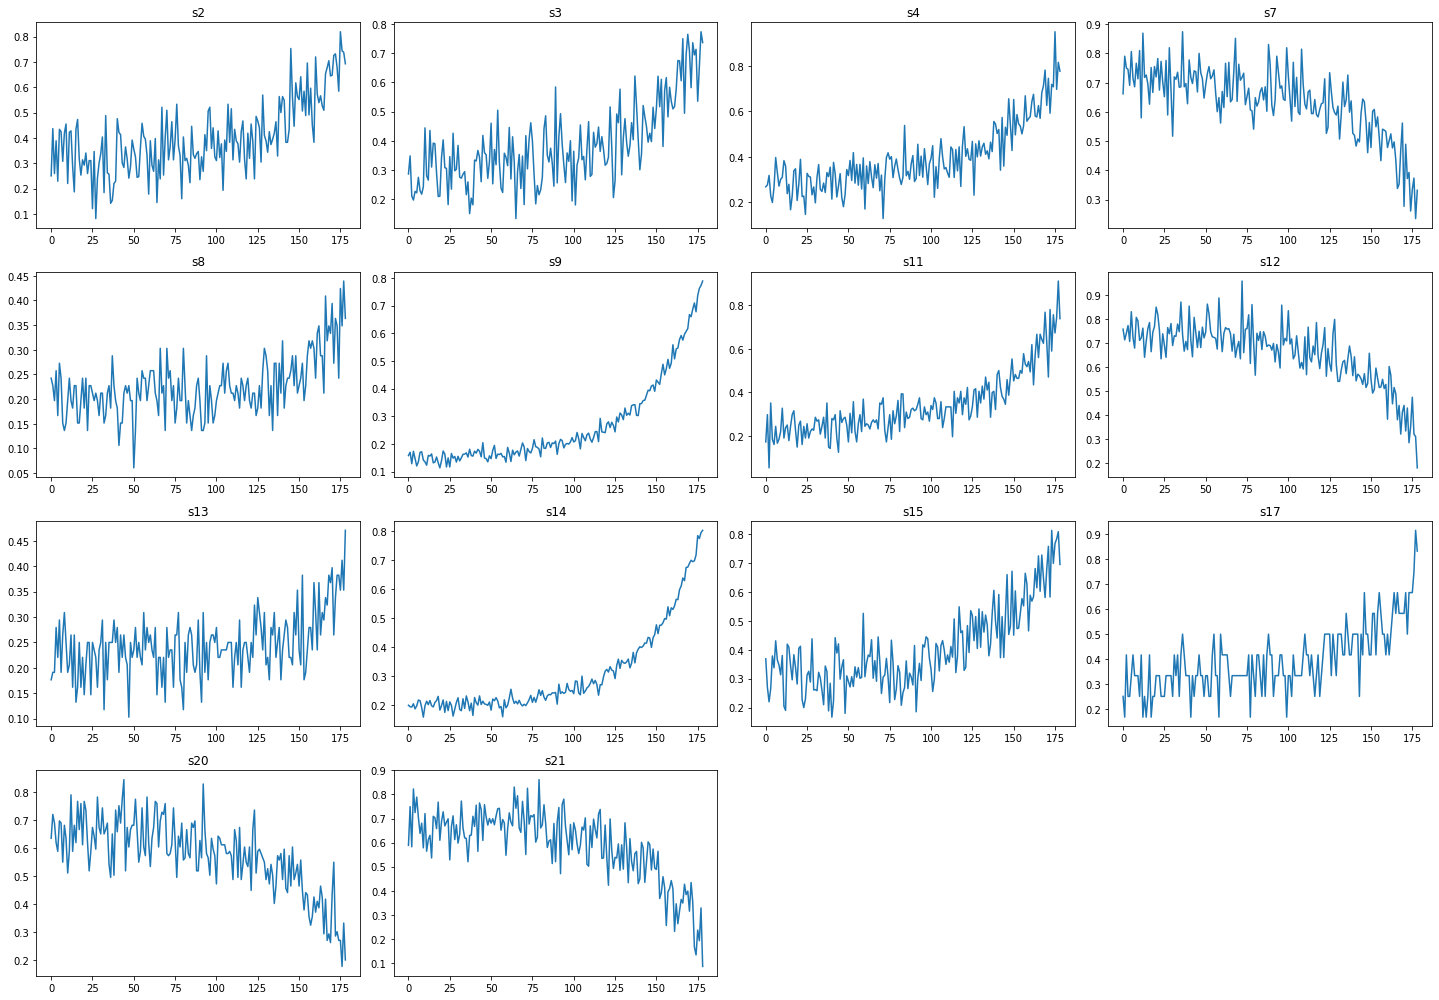

In [65]:
display_data( train_df, 3, sensor_cols)

rows: 4, cols: 4
Engine: 3, Samples: 179, Features: 14


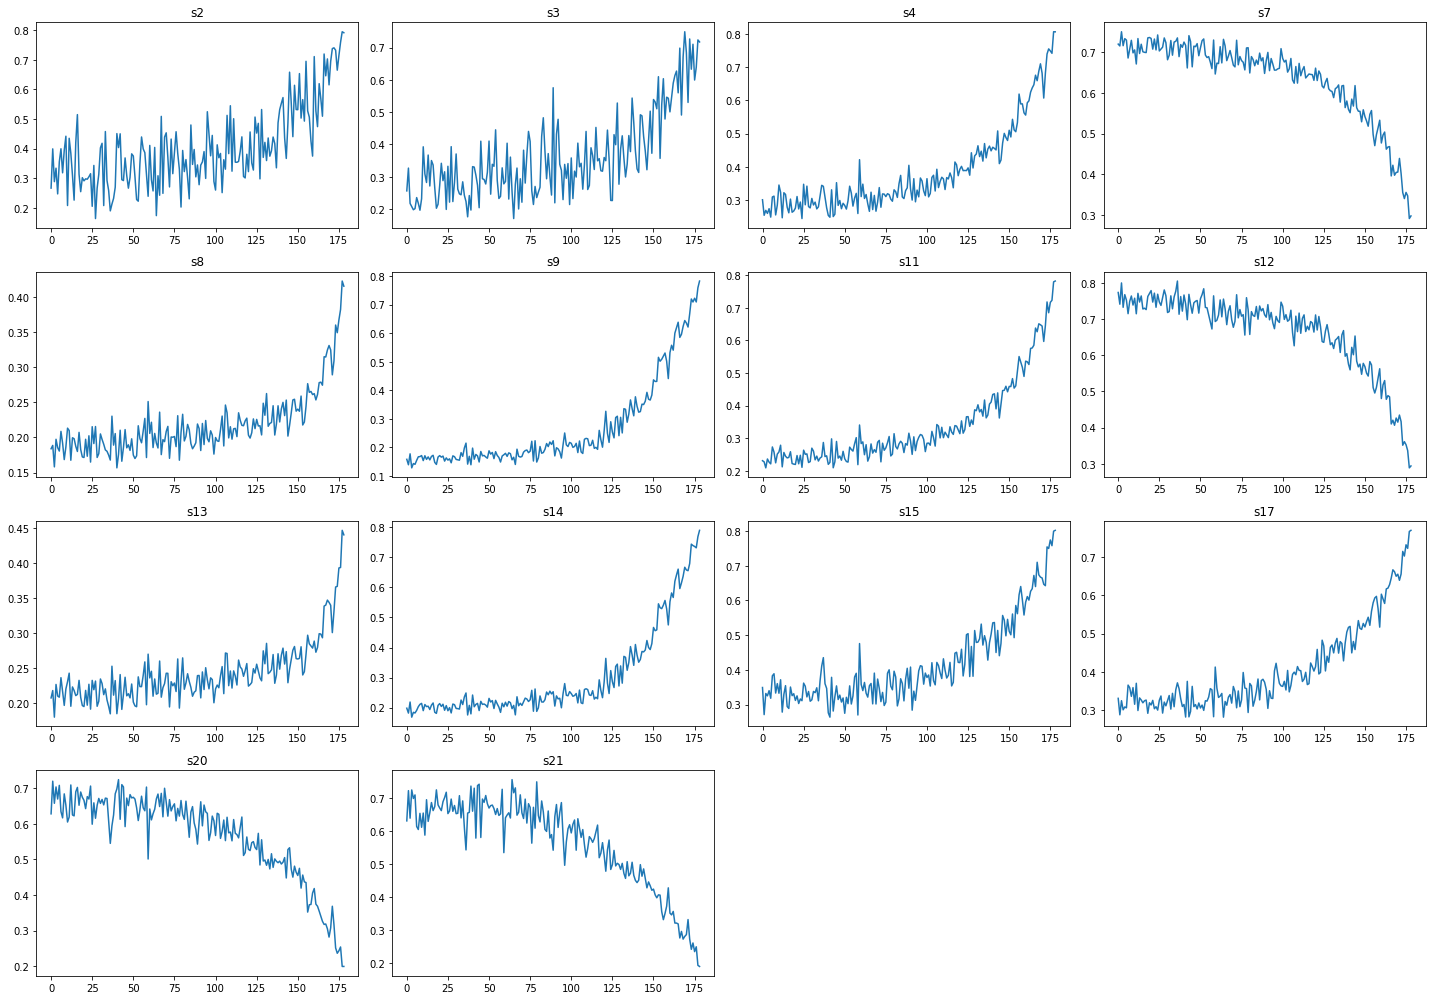

In [68]:
display_data( autoencoder_df, 3, sensor_cols)

In [0]:
def display_multiple(df, engines, col_names):
    
    engine_data = []
    
    for i in engines:
        engine_id = i+1
        engine = train_df[train_df['id'] == engine_id]
        engine_data.append(engine)
        
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = n // nrows
    
    fig = plt.figure(figsize=(20, n))
        
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(m)
        
        for i in range(len(engine_data)):
            e = engine_data[i]
            x = np.arange(e.shape[0])
            y = e[m].values
            ax.plot(x, y)
    
    plt.tight_layout()
    plt.show()

In [0]:
engine_ids

[24, 48]

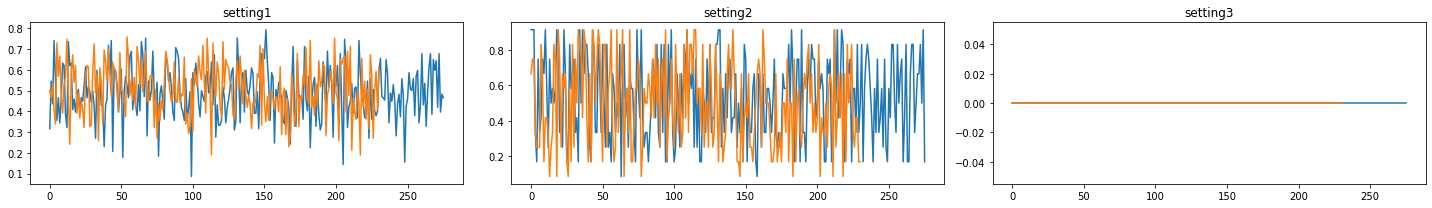

In [0]:

# Compare 10 random engines

num_engines = train_df.groupby(['id']).count().shape[0]
engine_ids = random.sample(range(1,num_engines), 2)
display_multiple( train_df, engine_ids, setting_cols)

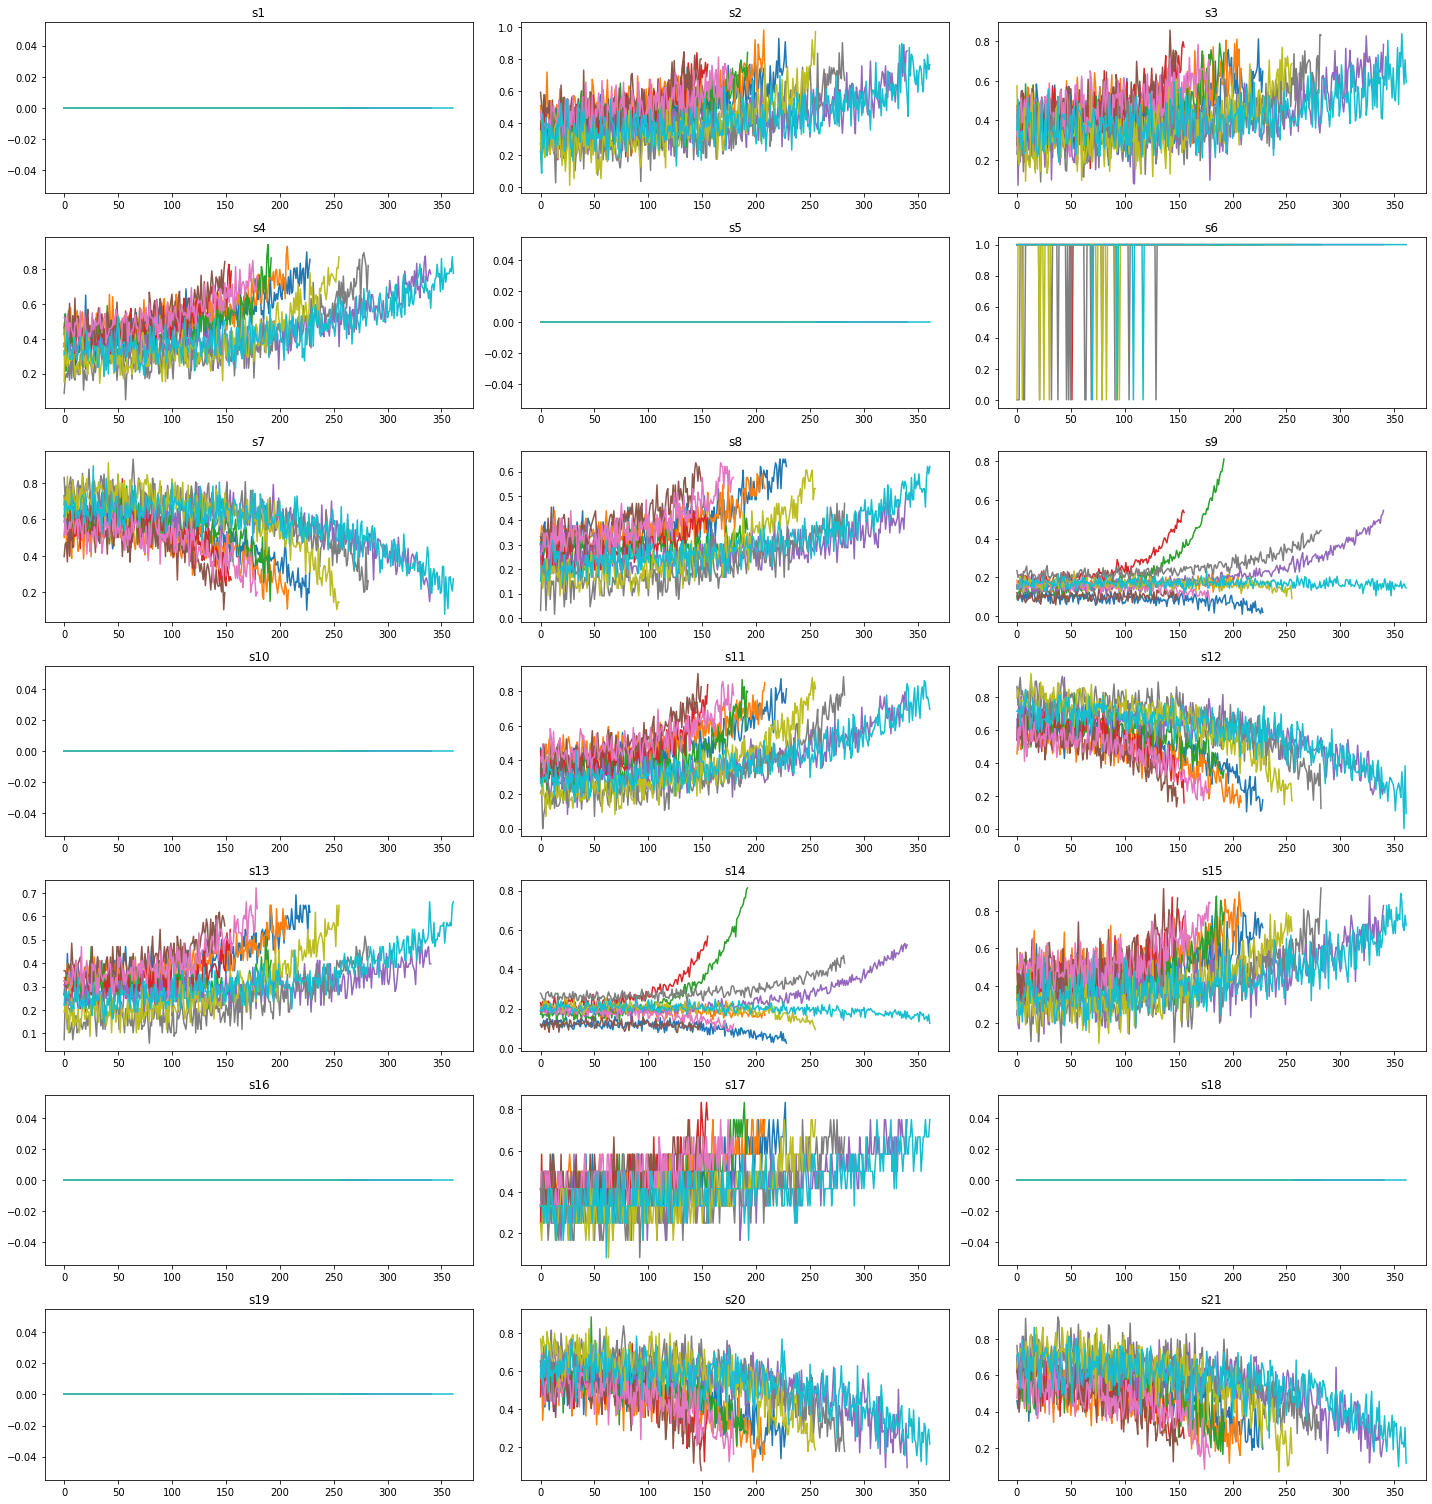

In [0]:

# Compare 10 random engines

engine_ids = random.sample(range(1,num_engines), 10)
display_multiple( train_df, engine_ids, sensor_cols)

[3, 70, 97, 82, 64, 13, 96, 25, 94, 16]


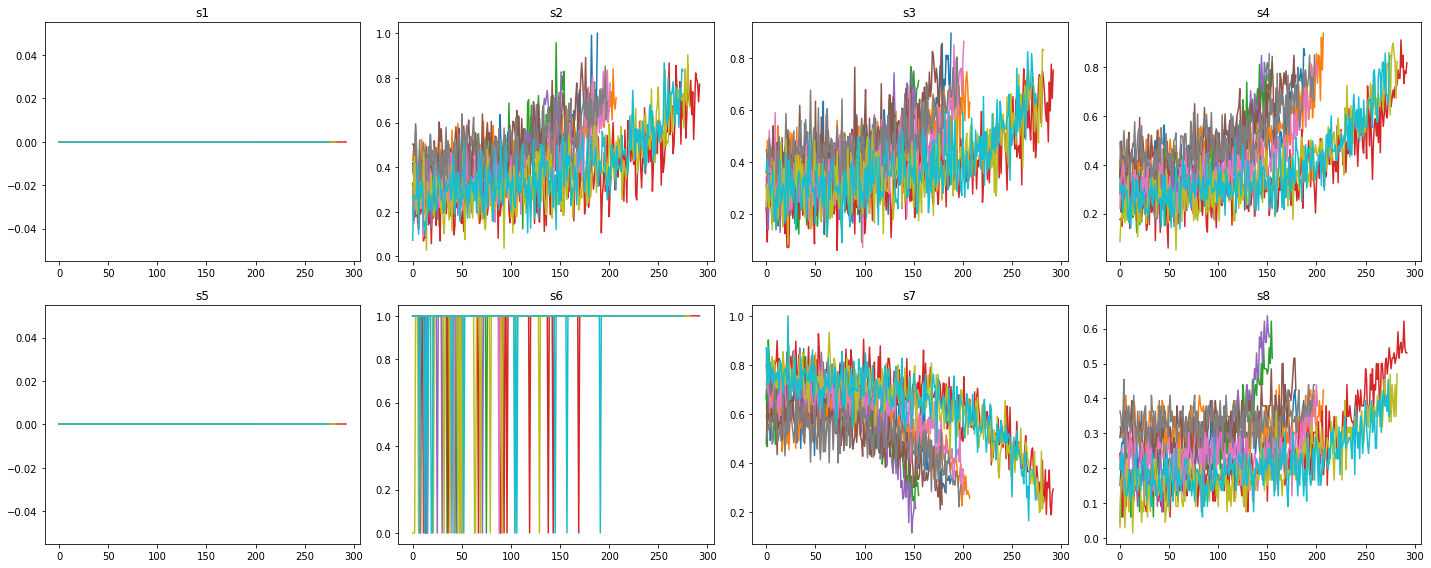

In [0]:
engine_ids = random.sample(range(1,num_engines), 10)
print(engine_ids)
display_multiple( encoded_df, engine_ids, encoded_cols)

In [0]:
def display_combined(df1,df2,engine_id, col_names):
    
    engine_data = []
    
    engine_data.append(df1[df1['id'] == engine_id])
    engine_data.append(df2[df2['id'] == engine_id])
        
    # Total plots 
    n = len(col_names)
     
    nrows = n // 3
    ncols = math.ceil(n / nrows)
    
    fig = plt.figure(figsize=(20, n))
        
    for i, m in enumerate(col_names):
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(m)
        
        for i in range(len(engine_data)):
            e = engine_data[i]
            x = np.arange(e.shape[0])
            y = e[m].values
            ax.plot(x, y)
    
    plt.tight_layout()
    plt.show()

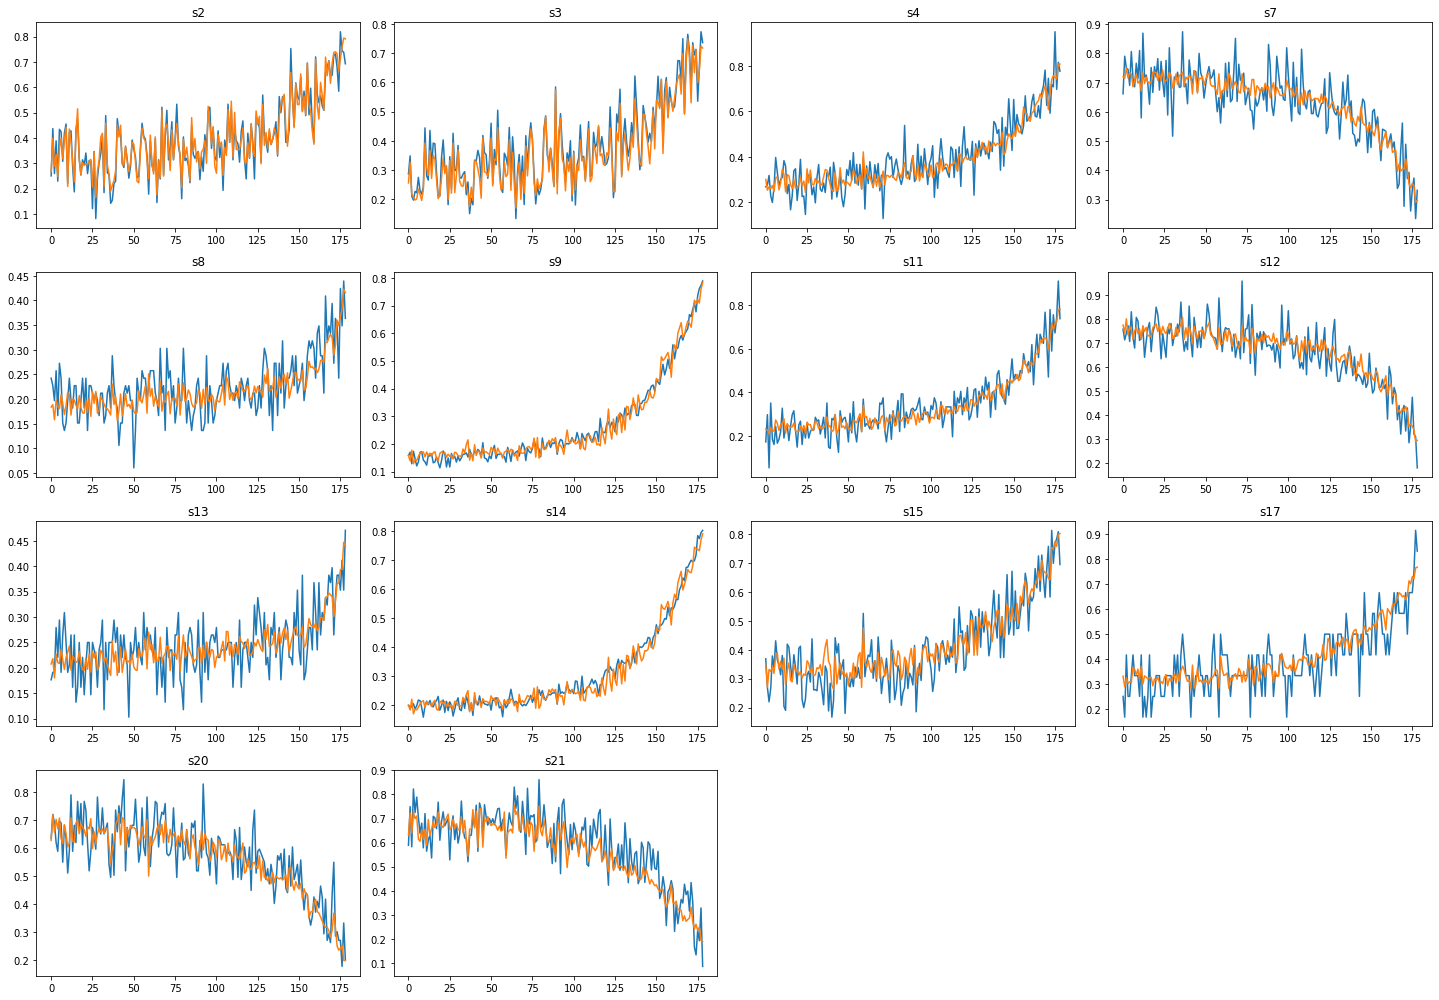

In [72]:
display_combined(train_df,autoencoder_df,3,sensor_cols)